## Задание 1


ФИО: Якимов Борис Павлович

Данные о количестве пассажиров

https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line



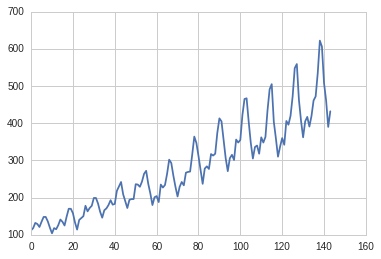

In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', 
                          usecols=[1], delimiter=",",
                          engine='python',
                          skipfooter=3)
plt.plot(dataset)
plt.show()

In [2]:
# подготовливаем данные
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [3]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


(96, 48)


In [4]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in xrange(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [5]:
# Пример подготовленных данных
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Используя torch.nn.LSTM сделать решить задачу предсказания временного ряда
1. one to one
2. many to one

Попробовать разные размеры окон и torch.nn.GRU вместо LSTM


In [6]:
import torch
from torch import optim
from torch import nn
from torch.autograd import Variable

In [7]:
trainX_t = Variable(torch.from_numpy(trainX).type(torch.FloatTensor),requires_grad=False)
trainY_t = Variable(torch.from_numpy(trainY).type(torch.FloatTensor),requires_grad=False)

testX_t = Variable(torch.from_numpy(testX).type(torch.FloatTensor),volatile=True)
testY_t = Variable(torch.from_numpy(testY).type(torch.FloatTensor),volatile=True)

In [8]:
trainX_t.size()

torch.Size([94, 1, 1])

### 0.Простая LSTM

In [9]:
rnn = nn.LSTM(input_size=1,hidden_size=1,num_layers=1)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=rnn.parameters(),lr=0.001,weight_decay=1e-6)

loss_train = []
loss_test = []
n_epochs = 7500

#input size hidden_size number of recurrent layers

In [10]:
import tqdm

In [11]:
patience_limit = 100 
patience = 0

In [12]:
rnn.train()
for epoch in xrange(n_epochs):
    optimizer.zero_grad()
    output,(h0,c0) = rnn.forward(trainX_t)
    loss = loss_fn(output.view(-1),trainY_t)
    loss.backward()
    optimizer.step()
    loss_train.append(loss.data[0])
    
    loss_test.append(loss_fn(rnn.forward(testX_t)[0],testY_t).data[0])
    
    if epoch%200==0:
        print "epoch:",epoch,"loss train:",loss_train[-1],"loss test:",loss_test[-1]
    
    if epoch > 4000:
        if loss_test[-1] > loss_test[-2]:
            patience += 1
    if patience > patience_limit:
        print "Oops! Early stoping!"
        break

epoch: 0 loss train: 0.255550354719 loss test: 0.696715652943
epoch: 200 loss train: 0.113927677274 loss test: 0.447938144207
epoch: 400 loss train: 0.0441147349775 loss test: 0.303433388472
epoch: 600 loss train: 0.0241194739938 loss test: 0.243548437953
epoch: 800 loss train: 0.0181530714035 loss test: 0.206146985292
epoch: 1000 loss train: 0.015647539869 loss test: 0.180722087622
epoch: 1200 loss train: 0.0131673282012 loss test: 0.159127801657
epoch: 1400 loss train: 0.010051779449 loss test: 0.133870705962
epoch: 1600 loss train: 0.00667123775929 loss test: 0.104013621807
epoch: 1800 loss train: 0.00449306378141 loss test: 0.0782887712121
epoch: 2000 loss train: 0.00398376816884 loss test: 0.0652587935328
epoch: 2200 loss train: 0.0037977239117 loss test: 0.0586511977017
epoch: 2400 loss train: 0.00364892464131 loss test: 0.0535039640963
epoch: 2600 loss train: 0.00352580822073 loss test: 0.0489988327026
epoch: 2800 loss train: 0.00342327007093 loss test: 0.0450311899185
epoch: 30

В итоге, я обучал порядка 7500 эпох (учится быстро). Реализовал на всякий случай раннюю остановку, однако, видимо, из-за явной скоррелированности данных, она не особо работает. Надо сказать, что работает. Однако, видно модель может быть

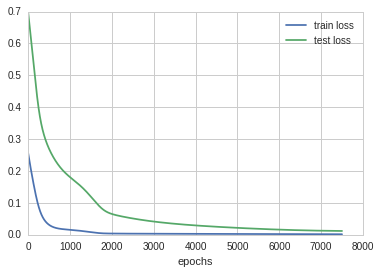

In [13]:
def plot_loss(loss_train,loss_test,yscale='linear',ax=plt.figure()):
    plt.plot(loss_train,label='train loss')
    plt.plot(loss_test,label='test loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.yscale(yscale)
    
plot_loss(loss_train,loss_test)

In [14]:
rnn.eval()
pred_y = rnn.forward(testX_t)
pred_y = pred_y[0].view(-1).data.numpy()

def plot_predicted(pred_y,testY):
    plt.plot(pred_y,'o-',label='Predicted RNN output')
    plt.plot(testY,'o-',label='ground truth output')
    plt.legend()

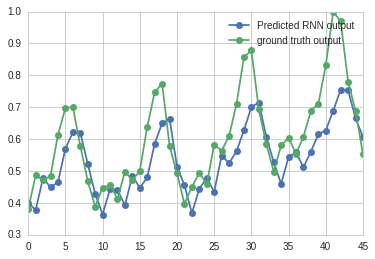

In [15]:
plot_predicted(pred_y,testY)

В принципе, модель добилась достаточно неплохих результатов в предсказании варьирования сезонности, однако тренд при этом улавливается не слишком четко, хочется добиться лучших результатов предсказаний, попробуем увеличить количество скрытых слоёв. (Возможно, такая модель слишком простая)

### 1. Два слоя LSTM (1 -> 1-> 1 (one to one)) 

In [16]:
class RNN_LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_size=1,output_size=1):
        super(RNN_LSTM,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
    
        self.cell= nn.LSTMCell
        self.layer_1 = self.cell(input_size,hidden_size)
        self.layer_2 = self.cell(hidden_size,output_size)
        
    def forward(self,input):
        outputs = []
        h_t = Variable(torch.zeros(input.size(1),self.hidden_size)
                       ,requires_grad=False)
        c_t = Variable(torch.zeros(input.size(1),self.hidden_size)
                       ,requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(1),self.output_size)
                        ,requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(1),self.output_size)
                        ,requires_grad=False)
        
       
        for i in xrange(input.size(0)):
            h_t, c_t = self.layer_1(input[i], (h_t, c_t))
            h_t2, c_t2 = self.layer_2(c_t, (h_t2, c_t2))
            outputs += [c_t2]
            
            
        outputs = torch.stack(outputs, dim=0).squeeze(2)
        return outputs

In [27]:
rnn = RNN_LSTM()

loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=rnn.parameters(),lr=0.003,weight_decay=1e-6)

loss_train = []
loss_test = []
n_epochs = 7500
patience_limit = 100 
patience = 0

epoch: 0 loss train: 2.39208364487 loss test: 1.02579891682
epoch: 100 loss train: 0.0503172315657 loss test: 0.0777881890535
epoch: 200 loss train: 0.0173484534025 loss test: 0.17811049521
epoch: 300 loss train: 0.0165667124093 loss test: 0.178004413843
epoch: 400 loss train: 0.0157926063985 loss test: 0.170483037829
epoch: 500 loss train: 0.0148343797773 loss test: 0.160929709673
epoch: 600 loss train: 0.0134328845888 loss test: 0.146598726511
epoch: 700 loss train: 0.0110657569021 loss test: 0.121670007706
epoch: 800 loss train: 0.00706446031108 loss test: 0.0776844248176
epoch: 900 loss train: 0.00407709134743 loss test: 0.039732478559
epoch: 1000 loss train: 0.00394990993664 loss test: 0.0354668796062
epoch: 1100 loss train: 0.00394023628905 loss test: 0.0353835523129
epoch: 1200 loss train: 0.00392856122926 loss test: 0.0353228449821
epoch: 1300 loss train: 0.00391444005072 loss test: 0.0352497026324
epoch: 1400 loss train: 0.00389741547406 loss test: 0.0351626910269
epoch: 1500 

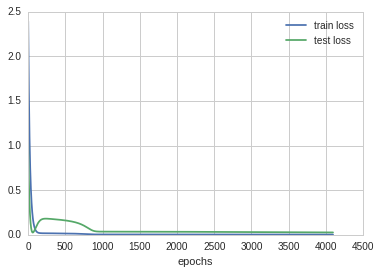

Continue? y/n/set p:n


In [28]:
rnn.train()
for epoch in xrange(n_epochs):
    optimizer.zero_grad()
    output = rnn.forward(trainX_t)
    loss = loss_fn(output,trainY_t)
            
    loss_train.append(loss.data[0])
    loss_test.append(loss_fn(rnn.forward(testX_t),testY_t).data[0])
    loss.backward()

    optimizer.step()
    
    if epoch%100==0:
        print "epoch:",epoch,"loss train:",loss_train[-1],"loss test:",loss_test[-1]
    
    if epoch > 3000:
        if loss_test[-1] > loss_test[-2]:
            patience += 1
    if patience > patience_limit:
        print "Oops! Early stoping!"
        plot_loss(loss_train,loss_test)
        plt.show()
        ans = raw_input("Continue? y/n/set p:")
        if ans=='y':
            patience = 0
        else:
            break

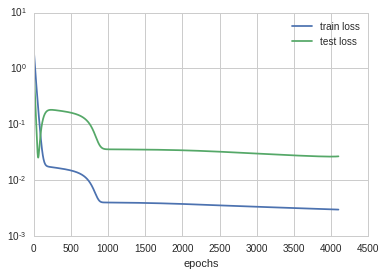

In [29]:
plot_loss(loss_train,loss_test,'log')

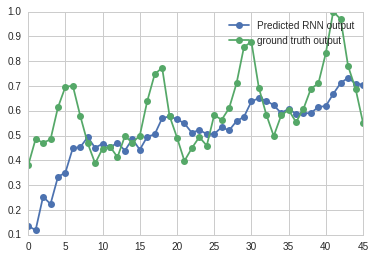

In [30]:
rnn.eval()
pred_y = rnn.forward(testX_t)
pred_y = pred_y.view(-1).data.numpy()

plot_predicted(pred_y=pred_y,testY=testY)

Почему-то с увеличением глубины "без расширения" мне не удалось добиться хороших результатов.

### 2. Many to one

In [37]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX_t = Variable(torch.from_numpy(trainX).type(torch.FloatTensor),requires_grad=False)
trainY_t = Variable(torch.from_numpy(trainY).type(torch.FloatTensor),requires_grad=False)

testX_t = Variable(torch.from_numpy(testX).type(torch.FloatTensor),volatile=True)
testY_t = Variable(torch.from_numpy(testY).type(torch.FloatTensor),volatile=True)

In [38]:
rnn = RNN_LSTM(input_size=2,hidden_size=1,output_size=1)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=rnn.parameters(),lr=0.003,weight_decay=1e-6)

loss_train = []
loss_test = []
n_epochs = 7500
patience_limit = 100 
patience = 0

epoch: 0 loss train: 0.261011362076 loss test: 0.644428431988
epoch: 100 loss train: 0.0248192530125 loss test: 0.211309567094
epoch: 200 loss train: 0.01079868339 loss test: 0.108617581427
epoch: 300 loss train: 0.00791275128722 loss test: 0.0761710330844
epoch: 400 loss train: 0.00487424107268 loss test: 0.035718858242
epoch: 500 loss train: 0.00415084930137 loss test: 0.0245095044374
epoch: 600 loss train: 0.00400317227468 loss test: 0.0246419161558
Oops! Early stoping!


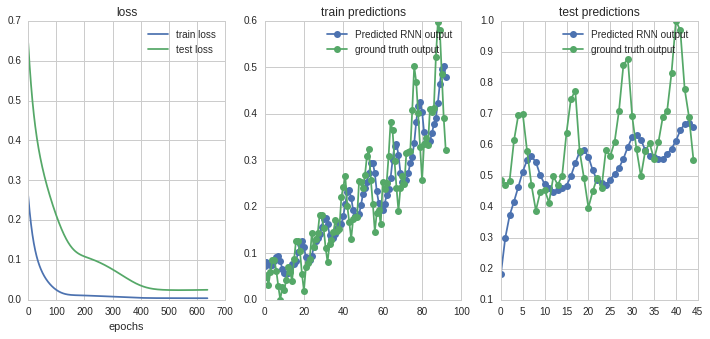

Continue? y/n/set p:y
epoch: 700 loss train: 0.00387453124858 loss test: 0.0259069576859
Oops! Early stoping!


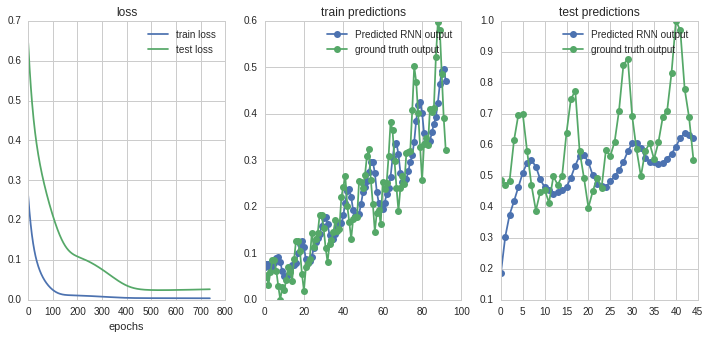

Continue? y/n/set p:n


In [39]:
rnn.train()
for epoch in xrange(n_epochs):

    optimizer.zero_grad()
    output = rnn.forward(trainX_t)
    loss = loss_fn(output,trainY_t)
            
    loss_train.append(loss.data[0])
    loss_test.append(loss_fn(rnn.forward(testX_t),testY_t).data[0])
    loss.backward()

    optimizer.step()
    
    if epoch%100==0:
        print "epoch:",epoch,"loss train:",loss_train[-1],"loss test:",loss_test[-1]
    
    if epoch > 1:
        if loss_test[-1] > loss_test[-2]:
            patience += 1
        else:
            patience = 0
    if patience > patience_limit:
        print "Oops! Early stoping!"
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        plot_loss(loss_train,loss_test)
        plt.title('loss')
        
        plt.subplot(1,3,2)
        pred_y = rnn.forward(trainX_t)
        pred_y = pred_y.view(-1).data.numpy()
        plot_predicted(pred_y=pred_y,testY=trainY)
        plt.title('train predictions')
        
        plt.subplot(1,3,3)
        pred_y = rnn.forward(testX_t)
        pred_y = pred_y.view(-1).data.numpy()
        plot_predicted(pred_y=pred_y,testY=testY)
        plt.title('test predictions')
        
        plt.show()
        
        ans = raw_input("Continue? y/n/set p:")
        if ans=='y':
            patience = 0
        elif ans=='set p':
            print 'Old patience limit:',patience_limit
            patience_limit = int(raw_input('Print new patience limit:'))
            patience = 0
        else:
            break

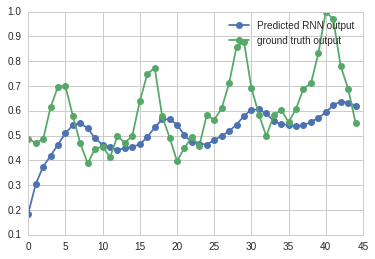

In [40]:
pred_y = rnn.forward(testX_t)
pred_y = pred_y.view(-1).data.numpy()

plot_predicted(pred_y=pred_y,testY=testY)

Почему-то, лучших результатов с many to one мне добиться не удалось.

### 3. GRU Cell

In [44]:
class RNN_GRU(nn.Module):
    def __init__(self,input_size=1,hidden_size=1,output_size=1):
        super(RNN_GRU,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
    
        self.cell= nn.GRUCell
        self.layer_1 = self.cell(input_size,hidden_size)
        self.layer_2 = self.cell(hidden_size,output_size)
        
    def forward(self,input):
        outputs = []
        h_t = Variable(torch.zeros(input.size(1),self.hidden_size)
                       ,requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(1),self.output_size)
                        ,requires_grad=False)

       
        for i in xrange(input.size(0)):
            h_t = self.layer_1(input[i], h_t)
            h_t2 = self.layer_2(h_t, h_t)
            outputs += [h_t2]
        
        outputs = torch.stack(outputs, dim=0).squeeze(2)
        h_t.detach()
        h_t2.detach()
        return outputs

In [45]:
rnn = RNN_GRU(input_size=2,hidden_size=1,output_size=1)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=rnn.parameters(),lr=0.003,weight_decay=1e-6)

loss_train = []
loss_test = []
n_epochs = 7500
patience_limit = 100 
patience = 0

epoch: 0 loss train: 0.0114929126576 loss test: 0.0539256930351
epoch: 100 loss train: 0.00613261060789 loss test: 0.06086814031
epoch: 200 loss train: 0.0039032662753 loss test: 0.0397858805954
epoch: 300 loss train: 0.00269004935399 loss test: 0.0260128770024
epoch: 400 loss train: 0.00231113051996 loss test: 0.0197264943272
epoch: 500 loss train: 0.00220900541171 loss test: 0.0174214858562
epoch: 600 loss train: 0.00215029134415 loss test: 0.0165300145745
epoch: 700 loss train: 0.00209728931077 loss test: 0.0160270668566
epoch: 800 loss train: 0.00204701116309 loss test: 0.0156130231917
epoch: 900 loss train: 0.00199961313047 loss test: 0.0152200590819
epoch: 1000 loss train: 0.00195549661294 loss test: 0.0148385176435
epoch: 1100 loss train: 0.0019150567241 loss test: 0.0144705027342
epoch: 1200 loss train: 0.0018786090659 loss test: 0.014119528234
epoch: 1300 loss train: 0.00184635643382 loss test: 0.0137885659933
epoch: 1400 loss train: 0.00181835668627 loss test: 0.0134798251092

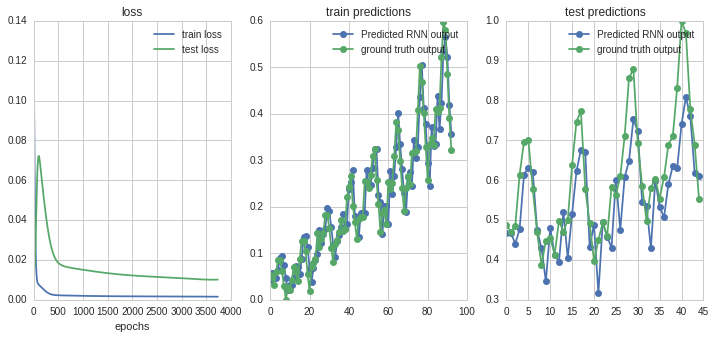

Continue? y/n/set p:n


In [48]:
rnn.train()
for epoch in xrange(n_epochs):

    optimizer.zero_grad()
    output = rnn.forward(trainX_t)
    loss = loss_fn(output,trainY_t)
            
    loss_train.append(loss.data[0])
    loss_test.append(loss_fn(rnn.forward(testX_t),testY_t).data[0])
    loss.backward()

    optimizer.step()
    
    if epoch%100==0:
        print "epoch:",epoch,"loss train:",loss_train[-1],"loss test:",loss_test[-1]
    
    if epoch > 1:
        if loss_test[-1] > loss_test[-2]:
            patience += 1
        else:
            patience = 0
    if patience > patience_limit:
        print "Oops! Early stoping!"
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        plot_loss(loss_train,loss_test)
        plt.title('loss')
        
        plt.subplot(1,3,2)
        pred_y = rnn.forward(trainX_t)
        pred_y = pred_y.view(-1).data.numpy()
        plot_predicted(pred_y=pred_y,testY=trainY)
        plt.title('train predictions')
        
        plt.subplot(1,3,3)
        pred_y = rnn.forward(testX_t)
        pred_y = pred_y.view(-1).data.numpy()
        plot_predicted(pred_y=pred_y,testY=testY)
        plt.title('test predictions')
        
        plt.show()
        
        ans = raw_input("Continue? y/n/set p:")
        if ans=='y':
            patience = 0
        elif ans=='set p':
            print 'Old patience limit:',patience_limit
            patience_limit = int(raw_input('Print new patience limit:'))
            patience = 0
        else:
            break

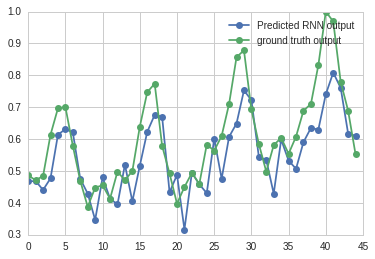

In [49]:
pred_y = rnn.forward(testX_t)
pred_y = pred_y.view(-1).data.numpy()

plot_predicted(pred_y=pred_y,testY=testY)

many to one GRU Cell пока дала наиболее приятные результаты, по сравнению с остальными. (Подбор гиперпараметров проводился не особо тщательно)

## Задание 2

Сделать датасет из двоичных чисел содежащих по N цифр. 
Обучить RNN: (2N -> N) - (2 числа записанные друг за другом) -> (сложение по модулю 2 ** N) . 

In [50]:
N = 10

In [51]:
datasize = 10000

In [52]:
numbers = []
answers = []
for x in xrange(datasize):
    a = np.random.randint(low=0,high=2**N)
    b = np.random.randint(low=0,high=2**N)
    numbers.append((a,b))
    answers.append((a + b)%(2**N))

In [53]:
numbers = np.array(numbers)

In [54]:
X = np.zeros((datasize,N,1,2))

In [55]:
for i in xrange(datasize):
    for j,(val_1,val_2) in enumerate(zip(np.binary_repr(numbers[i][0],width=N),
                     np.binary_repr(numbers[i][1],width=N))[::-1]):
        X[i,j,0,0] = int(val_1)
        X[i,j,0,1] = int(val_2)

In [56]:
Y = np.zeros((datasize,N,1,1))

for i in xrange(datasize):
    for j,val in enumerate(np.binary_repr(answers[i],width=N)[::-1]):
        Y[i,j,0,0] = int(val)

In [57]:
batchsize = 1

In [58]:
X = X.reshape((datasize/batchsize,N,batchsize,2))
Y = Y.reshape((datasize/batchsize,N,batchsize,1))

In [59]:
trainX, trainY = X[:int(X.shape[0]*0.8)],Y[:int(Y.shape[0]*0.8)]
valX, valY = X[int(X.shape[0]*0.8):int(X.shape[0]*0.9)],Y[int(Y.shape[0]*0.8):int(Y.shape[0]*0.9)]
testX,testY = X[int(X.shape[0]*0.9):],Y[int(Y.shape[0]*0.9):]

In [60]:
trainX_t = Variable(torch.from_numpy(trainX).type(torch.FloatTensor),requires_grad=False)
trainY_t = Variable(torch.from_numpy(trainY).type(torch.FloatTensor),requires_grad=False)

valX_t = Variable(torch.from_numpy(valX).type(torch.FloatTensor),volatile=True)
valY_t = Variable(torch.from_numpy(valY).type(torch.FloatTensor),volatile=True)

testX_t = Variable(torch.from_numpy(testX).type(torch.FloatTensor),volatile=True)
testY_t = Variable(torch.from_numpy(testY).type(torch.FloatTensor),volatile=True)

In [75]:


rnn = nn.LSTM(input_size=2,hidden_size=1,num_layers=2)
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(params=rnn.parameters(),lr=0.01,weight_decay=1e-6)

loss_train = []
loss_test = []


In [76]:
import tqdm

In [77]:
n_epochs = 300

In [78]:
rnn.train()
loss_train_epochs = []
loss_test_epochs = []
for epoch in xrange(n_epochs):
    loss_train=[]
    loss_test=[]
    for i in np.random.permutation(trainX_t.size(0))[:50]:#trainX_t.size(0)):
        optimizer.zero_grad()
        output,(h_0,c_0)= rnn.forward(trainX_t[i])
        h_0.detach()
        c_0.detach()
        loss = loss_fn(output,trainY_t[i])
        loss.backward()
        optimizer.step()

        loss_train.append(loss.data[0])
    for j in xrange(100):
        loss_test.append(loss_fn(rnn.forward(valX_t[j])[0],valY_t[j]).data[0])
    
    loss_train_epochs.append(np.mean(loss_train))
    loss_test_epochs.append(np.mean(loss_test))
    if epoch%5 == 0:
        print "epoch:",epoch,"loss train:",loss_train_epochs[-1],"loss val:",loss_test_epochs[-1]

epoch: 0 loss train: 0.33706407994 loss val: 0.261434814781
epoch: 5 loss train: 0.223762884736 loss val: 0.232347832769
epoch: 10 loss train: 0.238544646204 loss val: 0.230414462611
epoch: 15 loss train: 0.234847026765 loss val: 0.228732256144
epoch: 20 loss train: 0.228599151969 loss val: 0.225871976465
epoch: 25 loss train: 0.22962384671 loss val: 0.223109317943
epoch: 30 loss train: 0.214252188802 loss val: 0.210343991704
epoch: 35 loss train: 0.216422697753 loss val: 0.207515754327
epoch: 40 loss train: 0.204308159798 loss val: 0.200146272108
epoch: 45 loss train: 0.197117187902 loss val: 0.196245434657
epoch: 50 loss train: 0.192044718266 loss val: 0.191830031611
epoch: 55 loss train: 0.204618480206 loss val: 0.187843520343
epoch: 60 loss train: 0.18134552747 loss val: 0.18629069306
epoch: 65 loss train: 0.186905034631 loss val: 0.186847581603
epoch: 70 loss train: 0.179334844649 loss val: 0.18095247604
epoch: 75 loss train: 0.180583191365 loss val: 0.179874921739
epoch: 80 loss 

Здесь следует отметить, что оптимизатор RMSprop работает гораздо лучше, чем Adam. Так, MSE для Adam сходился к 0.25 (что соответствует в среднем выходам на нейросети равным 0.5), но для RMSProp за ~20 эпох в каждой из которых обучение происходило по случайным 5000 примерам из выборки лосс стал меньше 0.25, а за 100 эпох уже стал порядка 0.1 и продолжил падение.

Ниже представлены результаты предсказаний округленные до 0 и 1 (по порогу 0.5) для первых 10 тестовых примеров

In [92]:
for i in xrange(10):
    print "ground truth",testY[i].reshape(-1)
    print "prediction  ",1.0*(rnn.forward(testX_t[i])[0].view(-1).data.numpy()>0.5)
    print " "

ground truth [ 0.  0.  0.  1.  0.  1.  0.  1.  1.  1.]
prediction   [ 0.  0.  0.  1.  0.  1.  0.  1.  1.  1.]
 
ground truth [ 0.  1.  1.  1.  1.  1.  0.  1.  0.  0.]
prediction   [ 0.  1.  1.  1.  1.  1.  0.  1.  0.  0.]
 
ground truth [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
prediction   [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
 
ground truth [ 1.  0.  0.  1.  0.  1.  0.  1.  0.  1.]
prediction   [ 1.  0.  0.  1.  0.  1.  0.  1.  0.  1.]
 
ground truth [ 1.  0.  0.  1.  0.  0.  0.  1.  1.  0.]
prediction   [ 1.  0.  0.  1.  0.  0.  0.  1.  1.  0.]
 
ground truth [ 0.  1.  0.  1.  0.  0.  1.  1.  0.  1.]
prediction   [ 0.  1.  0.  1.  0.  0.  1.  1.  0.  1.]
 
ground truth [ 1.  1.  0.  0.  1.  1.  0.  1.  0.  1.]
prediction   [ 1.  1.  0.  0.  1.  1.  0.  1.  0.  1.]
 
ground truth [ 1.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
prediction   [ 1.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
 
ground truth [ 1.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
prediction   [ 1.  0.  1.  0.  1.  0.  0.  0.  1.